## Setup

In [2]:
import os
from pathlib import Path
import datetime

from tqdm import tqdm
from dataclasses import dataclass, asdict
from typing import List, Dict, Optional, Union

import polars as pl 
import numpy as np
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler

In [3]:
# ============ RETURNS TO SIGNAL CONFIGS ============
MIN_SIGNAL: float = 0.0                         # Minimum value for the daily signal 
MAX_SIGNAL: float = 2.0                         # Maximum value for the daily signal 
SIGNAL_MULTIPLIER: float = 400.0                # Multiplier of the OLS market forward excess returns predictions to signal 

# ============ MODEL CONFIGS ============
CV: int = 10                                    # Number of cross validation folds in the model fitting
L1_RATIO: float = 0.5                           # ElasticNet mixing parameter
ALPHAS: np.ndarray = np.logspace(-8, 2, 100)  
MAX_ITER: int = 1000000                         # The maximum number of iterations

In [4]:
@dataclass
class DatasetOutput:
    X_train : pl.DataFrame 
    X_test: pl.DataFrame
    y_train: pl.Series
    y_test: pl.Series
    scaler: StandardScaler

@dataclass 
class ElasticNetParameters:
    l1_ratio : float 
    cv: int
    alphas: np.ndarray 
    max_iter: int 
    
    def __post_init__(self): 
        if self.l1_ratio < 0 or self.l1_ratio > 1: 
            raise ValueError("Wrong initializing value for ElasticNet l1_ratio")
        
@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float 
    min_signal : float = MIN_SIGNAL
    max_signal : float = MAX_SIGNAL

## Params and Helper Functions

In [5]:
ret_signal_params = RetToSignalParameters(
    signal_multiplier= SIGNAL_MULTIPLIER
)

enet_params = ElasticNetParameters(
    l1_ratio = L1_RATIO, 
    cv = CV, 
    alphas = ALPHAS, 
    max_iter = MAX_ITER
)

In [6]:
def load_trainset() -> pl.DataFrame:
    """
    Loads and preprocesses the training dataset.

    Returns:
        pl.DataFrame: The preprocessed training DataFrame.
    """
    return (
        pl.read_csv("train.csv")
        .rename({'market_forward_excess_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        ).head(-40)
    )

def load_testset() -> pl.DataFrame:
    """
    Loads and preprocesses the testing dataset.

    Returns:
        pl.DataFrame: The preprocessed testing DataFrame.
    """
    return (
        pl.read_csv("test.csv")
        .rename({'lagged_forward_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        )
    )

def feature_engineering(df: pl.DataFrame) -> pl.DataFrame:
    """
    Creates new features and cleans a DataFrame.

    Args:
        df (pl.DataFrame): The input Polars DataFrame.

    Returns:
        pl.DataFrame: The DataFrame with new features, selected columns, and no null values.
    """
    # vars_to_keep: List[str] = [
    #     "S2", "E2", "E3", "P9", "S1", "S5", "I2", "P8",
    #     "P10", "P12", "P13", "U1", "U2"
    # ]

    new_vars_to_keep: List[str] = [
        "D1", "I5", "E11", "V2", "S10", "P10", "M16", 
        "E16", "S11", "E2", "I4"
    ]

    return (
        df.with_columns(
            (pl.col("I2") - pl.col("I1")).alias("U1"),
            (pl.col("M11") / ((pl.col("I2") + pl.col("I9") + pl.col("I7")) / 3)).alias("U2")
        )
        .select(["date_id", "target"] + new_vars_to_keep)
        .with_columns([
            pl.col(col).fill_null(pl.col(col).ewm_mean(com=0.5))
            for col in new_vars_to_keep
        ])
        .drop_nulls()
    )
    
def join_train_test_dataframes(train: pl.DataFrame, test: pl.DataFrame) -> pl.DataFrame:
    """
    Joins two dataframes by common columns and concatenates them vertically.

    Args:
        train (pl.DataFrame): The training DataFrame.
        test (pl.DataFrame): The testing DataFrame.

    Returns:
        pl.DataFrame: A single DataFrame with vertically stacked data from common columns.
    """
    common_columns: list[str] = [col for col in train.columns if col in test.columns]
    
    return pl.concat([train.select(common_columns), test.select(common_columns)], how="vertical")

def split_dataset(train: pl.DataFrame, test: pl.DataFrame, features: list[str]) -> DatasetOutput: 
    """
    Splits the data into features (X) and target (y), and scales the features.

    Args:
        train (pl.DataFrame): The processed training DataFrame.
        test (pl.DataFrame): The processed testing DataFrame.
        features (list[str]): List of features to used in model. 

    Returns:
        DatasetOutput: A dataclass containing the scaled feature sets, target series, and the fitted scaler.
    """
    X_train = train.select(features)
    y_train = train.get_column('target')
    X_test = test.drop(['date_id','target']) 
    y_test = test.get_column('target')
    
    scaler = StandardScaler() 
    
    X_train_scaled_np = scaler.fit_transform(X_train)
    X_train = pl.from_numpy(X_train_scaled_np, schema=features)
    
    X_test_scaled_np = scaler.transform(X_test)
    X_test = pl.from_numpy(X_test_scaled_np, schema=features)
    
    
    return DatasetOutput(
        X_train = X_train,
        y_train = y_train, 
        X_test = X_test, 
        y_test = y_test,
        scaler = scaler
    )

## Exploratory Data Analysis

In [7]:
train: pl.DataFrame = load_trainset()
test: pl.DataFrame = load_testset() 
print(train.tail(3)) 
print(test.head(3))

shape: (3, 98)
┌─────────┬─────┬─────┬─────┬───┬───────────┬─────────────────┬────────────────┬───────────┐
│ date_id ┆ D1  ┆ D2  ┆ D3  ┆ … ┆ V9        ┆ forward_returns ┆ risk_free_rate ┆ target    │
│ ---     ┆ --- ┆ --- ┆ --- ┆   ┆ ---       ┆ ---             ┆ ---            ┆ ---       │
│ i64     ┆ f64 ┆ f64 ┆ f64 ┆   ┆ f64       ┆ f64             ┆ f64            ┆ f64       │
╞═════════╪═════╪═════╪═════╪═══╪═══════════╪═════════════════╪════════════════╪═══════════╡
│ 8978    ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ … ┆ -0.725858 ┆ 0.002279        ┆ 0.000162       ┆ 0.001805  │
│ 8979    ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ … ┆ -0.720092 ┆ 0.003541        ┆ 0.000161       ┆ 0.003068  │
│ 8980    ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ … ┆ -0.751909 ┆ -0.005964       ┆ 0.000162       ┆ -0.006437 │
└─────────┴─────┴─────┴─────┴───┴───────────┴─────────────────┴────────────────┴───────────┘
shape: (3, 99)
┌─────────┬─────┬─────┬─────┬───┬───────────┬───────────┬─────────────────────┬────────────────────┐
│ date_id ┆ D1  ┆ D2  ┆ D3  ┆ … 

In [8]:
train.null_count()

date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,…,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,target
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,1784,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1616,1006,1006,1006,1006,6969,1006,1006,1006,1006,1006,1006,1006,1006,1006,…,1006,1006,1006,1006,1574,1638,1616,1006,1006,1006,1006,1006,3537,1006,5733,1006,1511,1006,1006,3009,1006,1006,6049,1006,1006,1511,1006,1006,1006,1512,1006,1511,1006,4539,0,0,0


In [9]:
filtered_train = train[1006:]
filtered_train


date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,…,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,target
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1006,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,null,0.597222,0.035053,0.018519,0.005952,0.005952,0.520172,1.116487,0.680294,-0.199948,-0.882935,2.021695,null,1.794863,0.003638,0.864087,0.344577,null,-0.66887,0.003307,0.987103,-1.921693,0.597222,0.540344,-1.320764,0.650794,0.793651,…,0.573413,-1.576455,0.640873,0.087632,null,null,null,1.763894,0.652778,-1.059103,0.000661,0.000661,null,1.208733,null,0.000661,null,0.417989,0.607143,null,0.000661,0.000661,null,0.000661,0.000661,null,0.986772,0.970899,0.986111,null,0.000661,null,0.000661,null,-0.000669,0.000121,-0.0011
1007,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,null,0.597884,0.034722,0.018188,0.005622,0.005622,0.520503,1.116244,0.681505,-0.198796,-1.113241,2.020056,null,1.793937,0.003307,0.864418,0.345238,null,-0.723671,0.002976,0.977513,-1.977569,0.597884,0.565476,-1.31907,0.439815,0.779431,…,0.573743,-1.721848,0.367725,0.182209,null,null,null,1.760748,0.653439,-1.064294,0.000661,0.000661,null,1.207146,null,0.000661,null,0.470569,0.607474,null,0.000661,0.000661,null,0.000661,0.000661,null,0.984788,0.972884,0.984788,null,0.000661,null,0.000661,null,0.005348,0.000121,0.004917
1008,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,null,0.598545,0.034392,0.017857,0.005291,0.005291,0.520833,1.116002,0.682718,-0.197643,-1.113912,2.088565,null,1.901311,0.002976,0.864749,0.345899,null,-0.723964,0.002646,0.968585,-2.003693,0.598545,0.568783,-1.31237,0.431217,0.824735,…,0.574074,-1.589883,0.68254,0.559193,null,null,null,1.764136,0.654101,-1.063939,0.000661,0.000661,null,1.088541,null,0.000661,null,0.541667,0.607804,null,0.000661,0.000661,null,0.000661,0.000661,null,0.982143,0.834656,0.983466,null,0.000661,null,0.000661,null,0.001996,0.000121,0.001565
1009,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,null,0.599206,0.034061,0.017526,0.00496,0.00496,0.520503,1.115759,0.683934,-0.196487,-1.123683,2.094246,null,1.9116,0.002646,0.865079,0.346561,null,-0.724256,0.002315,0.965278,-1.990399,0.599206,0.546296,-1.310706,0.492063,0.799934,…,0.574405,-1.601599,0.890542,0.26455,null,null,null,1.761746,0.654762,-1.063491,0.000661,0.000661,null,0.618246,null,0.000661,null,0.62004,0.608135,null,0.000661,0.000661,null,0.000661,0.000661,null,0.980159,0.928571,0.979497,null,0.000661,null,0.000661,null,-0.001327,0.000121,-0.001758
1010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,null,0.599868,0.03373,0.017196,0.00463,0.00463,0.520172,1.115517,0.685153,-0.195329,-1.013534,2.082656,null,1.895303,0.002315,0.86541,0.347222,null,-0.72457,0.001984,0.968915,-1.967328,0.599868,0.545635,-1.339,0.460979,0.850198,…,0.574735,-1.594769,0.162037,0.962963,null,null,null,1.758974,0.655423,-1.068476,0.000661,0.000661,null,0.618119,null,0.000661,null,0.62037,0.608466,null,0.000661,0.000661,null,0.000661,0.000661,null,1.0,0.997354,1.0,null,0.000661,null,0.000661,null,-0.003987,0.000119,-0.004415
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
8976,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.58757,0.1875,0.002646,0.002646,0.002646,0.002646,0.953704,-0.584803,-0.706288,0.30139,0.010028,1.222709,1.39985,1.675815,0.034392,0.681548,0.037698,-0.039909,-0.304347,0.911706,0.297288,1.066023,0.089947,0.484788,0.685984,0.727513,0.299603,…,0.679233,-1.410109,0.546296,0.068783,-0.661479,-0.330399,2.245457,1.771512,0.042328,0.206443,0.169974,0.037037,0.029983,-0.041293,-0.251824,0.085317,0.126943,0.167328,0.409392,0.39

In [10]:
filtered_train.corr()

date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,…,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,target
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,-0.000178,-0.000178,0.000042,-0.010814,-0.000343,-0.000687,0.000933,0.00022,-0.000488,NaN,-0.222011,-0.340637,-0.329856,-0.156982,-0.193577,0.012565,-0.116793,-0.120411,-0.066774,-0.119258,-0.020986,NaN,-0.072554,0.222256,-0.144022,-0.49702,NaN,-0.026658,0.446729,-0.217995,0.213689,-0.364455,-0.256522,0.335742,0.033972,-0.352559,…,-0.027287,0.011924,-0.022259,-0.001797,NaN,NaN,NaN,-0.028393,-0.225932,-0.024322,0.338059,0.304801,NaN,-0.004737,NaN,0.344623,NaN,-0.078332,-0.236705,NaN,0.368279,0.581836,NaN,0.665758,0.555027,NaN,-0.009468,0.016742,-0.042423,NaN,0.574065,NaN,0.595211,NaN,0.003791,-0.431292,0.007144
-0.000178,1.0,1.0,-0.000658,0.007059,0.010835,0.00532,-0.032897,0.016196,-0.012334,NaN,0.002272,-0.001254,0.00155,-0.003867,0.00337,0.000013,0.001436,0.001205,0.000157,-0.027338,-0.000291,NaN,0.00063,0.002139,0.00032,-0.002714,NaN,-0.00197,0.001238,0.00313,0.002731,-0.000114,0.002465,0.004662,-0.003716,0.003567,…,0.006849,-0.002395,0.00417,0.007975,NaN,NaN,NaN,0.000206,-0.000262,0.000432,0.012963,0.016547,NaN,0.006142,NaN,0.009978,NaN,0.009369,0.006587,NaN,-0.013507,-0.002229,NaN,0.001608,0.001402,NaN,-0.003215,-0.008504,-0.004255,NaN,-0.008636,NaN,-0.001124,NaN,0.034134,0.00197,0.034139
-0.000178,1.0,1.0,-0.000658,0.007059,0.010835,0.00532,-0.032897,0.016196,-0.012334,NaN,0.002272,-0.001254,0.00155,-0.003867,0.00337,0.000013,0.001436,0.001205,0.000157,-0.027338,-0.000291,NaN,0.00063,0.002139,0.00032,-0.002714,NaN,-0.00197,0.001238,0.00313,0.002731,-0.000114,0.002465,0.004662,-0.003716,0.003567,…,0.006849,-0.002395,0.00417,0.007975,NaN,NaN,NaN,0.000206,-0.000262,0.000432,0.012963,0.016547,NaN,0.006142,NaN,0.009978,NaN,0.009369,0.006587,NaN,-0.013507,-0.002229,NaN,0.001608,0.001402,NaN,-0.003215,-0.008504,-0.004255,NaN,-0.008636,NaN,-0.001124,NaN,0.034134,0.00197,0.034139
0.000042,-0.000658,-0.000658,1.0,0.009095,-0.105023,0.107113,-0.049604,-0.088863,-0.090436,NaN,-0.001373,-0.000118,-0.000295,-0.006403,-0.012874,0.003211,0.00062,0.000297,-0.001149,-0.006766,-0.003167,NaN,-0.00276,-0.00522,-0.000354,-0.001776,NaN,0.000392,-0.000569,0.000897,0.001966,0.00047,-0.004671,-0.000339,-0.003832,0.000043,…,0.006085,0.002815,0.00055,0.011886,NaN,NaN,NaN,-0.001473,0.002981,-0.001629,0.01075,0.00544,NaN,0.004609,NaN,0.000307,NaN,0.002846,-0.000842,NaN,0.003669,0.001968,NaN,-0.005193,0.005311,NaN,0.001039,0.003396,-0.000039,NaN,-0.001348,NaN,0.001163,NaN,0.003923,-0.002421,0.003918
-0.010814,0.007059,0.007059,0.009095,1.0,0.007762,-0.007403,0.001282,0.006008,0.006847,NaN,0.091823,0.000768,0.01106,-0.076537,-0.007007,-0.005584,0.008685,0.000145,-0.062065,0.032835,0.002709,NaN,-0.005126,-0.053734,-0.041518,-0.024793,NaN,0.017238,-0.01614,-0.032331,0.019218,0.023157,-0.014292,0.005427,0.017779,-0.040915,…,0.091488,0.012829,0.025244,-0.002795,NaN,NaN,NaN,0.004442,0.00156,-0.02909,0.022947,0.047147,NaN,0.129929,NaN,0.042341,NaN,0.085059,0.000134,NaN,-0.090673,0.00553,NaN,0.012041,-0.02604,NaN,0.017464,0.026734,0.034339,NaN,-0.093817,NaN,0.014122,NaN,0.014921,-0.01007,0.014985
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.595211,-0.001124,-0.001124,0.001163,0.014122,0.000481,0.002886,-0.000249,-0.000969,0.00058,NaN,-0.073967,-0.282089,-0.267027,-0.096062,-0.12018,-0.191481,0.107815,0.141394,-0.000377,-0.06914,0.117265,NaN,-0.013543,0.211547,0.087667,-0.247287,NaN,-0.1

✓ Saved: correlation_matrix_upper.png


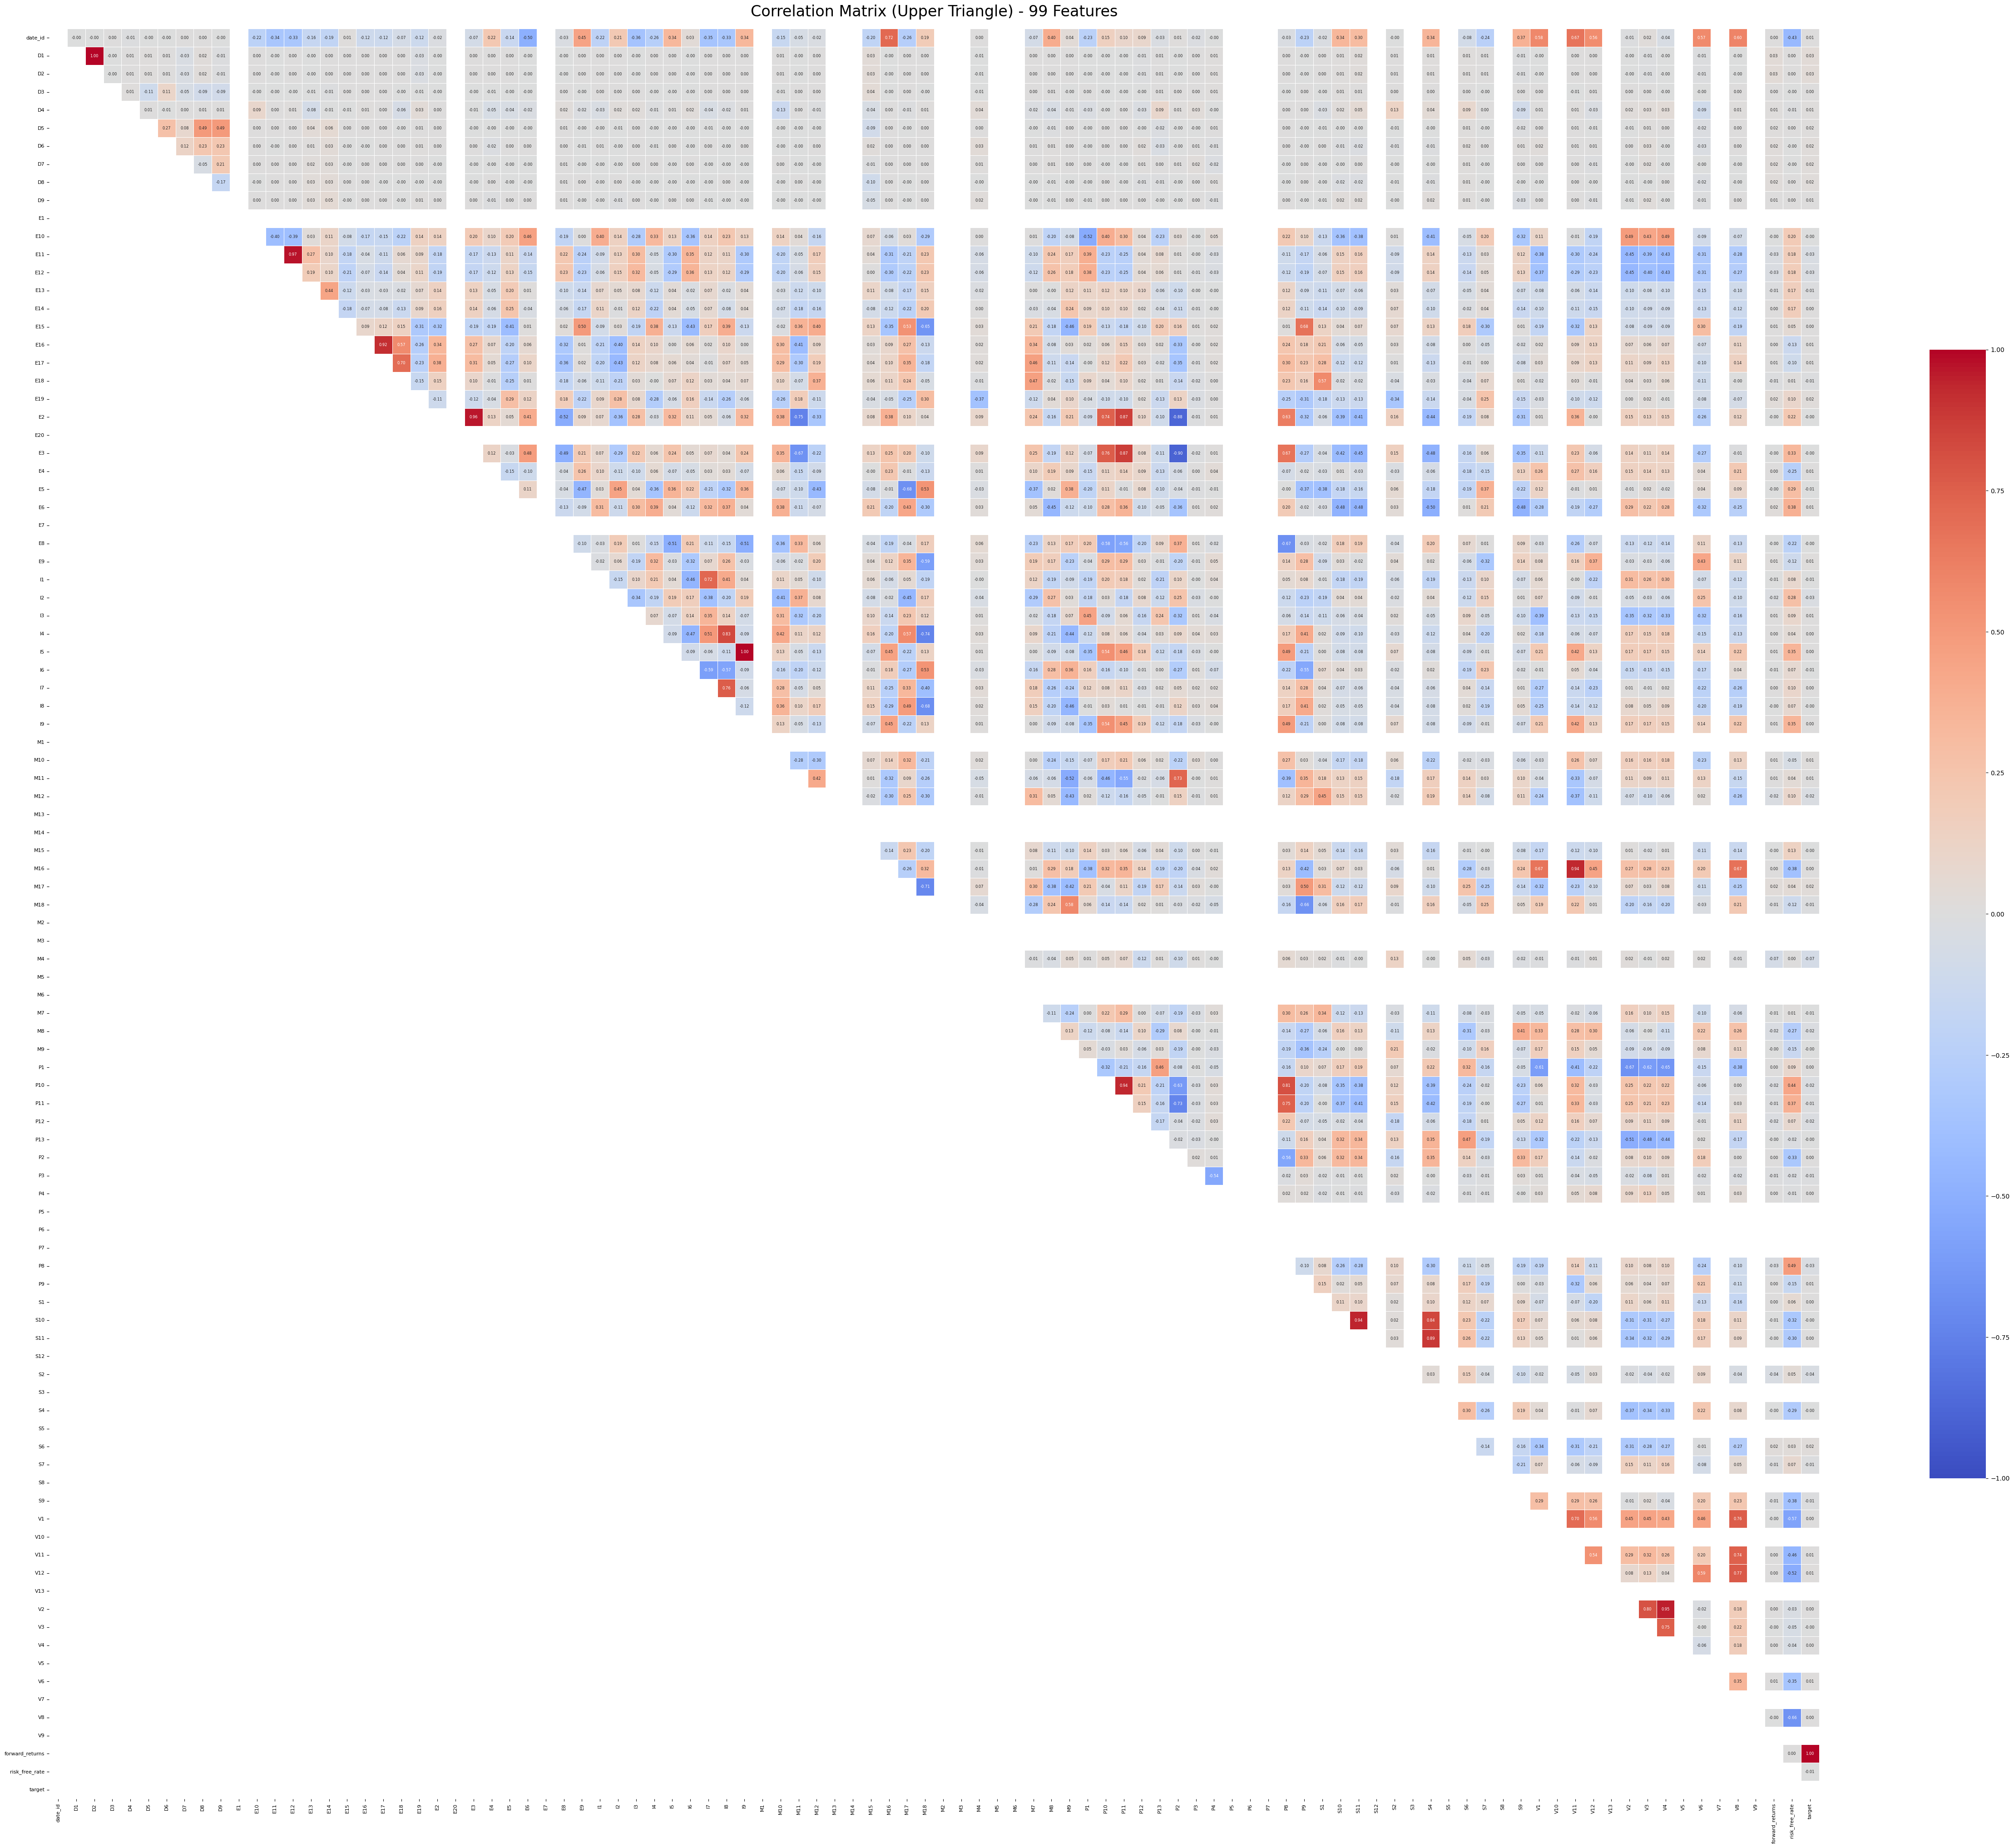

In [11]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr_np = filtered_train.corr().to_numpy()
feature_names = filtered_train.columns

mask = np.tril(np.ones_like(corr_np, dtype=bool))  # Lower triangle mask
corr_np_masked = corr_np.copy()
corr_np_masked[mask] = np.nan  # Hide lower triangle

# ============ Plot with Annotations ============
plt.figure(figsize=(50, 50))
sns.heatmap(corr_np_masked,
            mask=mask,              # Hide lower triangle
            cmap='coolwarm',
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.5},
            xticklabels=feature_names,
            yticklabels=feature_names,
            annot=True,             # Show correlation values!
            fmt='.2f',              # Format: 2 decimal places
            annot_kws={'size': 6})  # Annotation font size

plt.title('Correlation Matrix (Upper Triangle) - 99 Features', fontsize=24, pad=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('correlation_matrix_upper.png', dpi=300, bbox_inches='tight')
print("✓ Saved: correlation_matrix_upper.png")
plt.show()

### Notable Observations
- Forward Return is perfectly correlated with Target
- V4 is 95% correlated with V2
- S11 is 94% correlated with S10
- P11 is 94% correlated with P10
- I9 is perfectly correlated with I5?
- 

In [12]:
threshold = 0.8

high_corr_pairs = []
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):  # Upper triangle only
        corr_value = corr_np[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append({
                'feature_1': feature_names[i],
                'feature_2': feature_names[j],
                'correlation': round(corr_value, 4)
            })

if high_corr_pairs:
    high_corr_df = pl.DataFrame(high_corr_pairs).sort('correlation', descending=True)
else:
    print(f"\nNo pairs with |correlation| > {threshold}")

In [13]:
with pl.Config(tbl_rows=-1):
    print(high_corr_df)

shape: (19, 3)
┌─────────────────┬───────────┬─────────────┐
│ feature_1       ┆ feature_2 ┆ correlation │
│ ---             ┆ ---       ┆ ---         │
│ str             ┆ str       ┆ f64         │
╞═════════════════╪═══════════╪═════════════╡
│ D1              ┆ D2        ┆ 1.0         │
│ forward_returns ┆ target    ┆ 1.0         │
│ I5              ┆ I9        ┆ 0.9997      │
│ E11             ┆ E12       ┆ 0.9743      │
│ E2              ┆ E3        ┆ 0.9614      │
│ V2              ┆ V4        ┆ 0.9525      │
│ S10             ┆ S11       ┆ 0.9445      │
│ P10             ┆ P11       ┆ 0.9364      │
│ M16             ┆ V11       ┆ 0.9352      │
│ E16             ┆ E17       ┆ 0.9182      │
│ S11             ┆ S4        ┆ 0.8856      │
│ E3              ┆ P11       ┆ 0.87        │
│ E2              ┆ P11       ┆ 0.8669      │
│ S10             ┆ S4        ┆ 0.8397      │
│ I4              ┆ I8        ┆ 0.8298      │
│ P10             ┆ P8        ┆ 0.8068      │
│ V2              ┆

## Model Training

In [14]:
df: pl.DataFrame = join_train_test_dataframes(train, test)
df = feature_engineering(df=df) 
train: pl.DataFrame = df.filter(pl.col('date_id').is_in(train.get_column('date_id')))
test: pl.DataFrame = df.filter(pl.col('date_id').is_in(test.get_column('date_id')))

FEATURES: list[str] = [col for col in test.columns if col not in ['date_id', 'target']]

dataset: DatasetOutput = split_dataset(train=train, test=test, features=FEATURES) 

X_train: pl.DataFrame = dataset.X_train
X_test: pl.DataFrame = dataset.X_test
y_train: pl.DataFrame = dataset.y_train
y_test: pl.DataFrame = dataset.y_test
scaler: StandardScaler = dataset.scaler 

/var/folders/bg/6x82p8q55dxf8pb_c34j03mm0000gn/T/ipykernel_20211/66751569.py:3: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  train: pl.DataFrame = df.filter(pl.col('date_id').is_in(train.get_column('date_id')))
/var/folders/bg/6x82p8q55dxf8pb_c34j03mm0000gn/T/ipykernel_20211/66751569.py:4: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  test: pl.DataFrame = df.filter(pl.col('date_id').is_in(test.get_column('date_id')))


In [15]:
model_cv: ElasticNetCV = ElasticNetCV(
    **asdict(enet_params)
)
model_cv.fit(X_train, y_train) 
        
# Fit the final model using the best alpha found by cross-validation
model: ElasticNet = ElasticNet(alpha=model_cv.alpha_, l1_ratio=enet_params.l1_ratio) 
model.fit(X_train, y_train)
print(model)

ElasticNet(alpha=np.float64(0.00022051307399030456))


## Testing

In [16]:
def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters
) -> np.ndarray:
    """
    Converts raw model predictions (expected returns) into a trading signal.

    Args:
        ret_arr (np.ndarray): The array of predicted returns.
        params (RetToSignalParameters): Parameters for scaling and clipping the signal.

    Returns:
        np.ndarray: The resulting trading signal, clipped between min and max values.
    """
    return np.clip(
        ret_arr * params.signal_multiplier + 1, params.min_signal, params.max_signal
    )

def predict(test: pl.DataFrame) -> float:
    try:
        test = test.rename({'lagged_forward_returns':'target'})
    except:
        pass
    df: pl.DataFrame = feature_engineering(test)
    X_test: pl.DataFrame = df.select(FEATURES)
    X_test_scaled_np: np.ndarray = scaler.transform(X_test)
    X_test: pl.DataFrame = pl.from_numpy(X_test_scaled_np, schema=FEATURES)
    raw_pred: float = model.predict(X_test)[0]
    signal = convert_ret_to_signal(raw_pred, ret_signal_params)

    
    return raw_pred

In [22]:
predictions = []
actuals = []

test: pl.DataFrame = load_testset()


for row in test.iter_rows(named=True):
    # Create test-like structure
    test_row = pl.DataFrame([row])
    pred = predict(test_row)
    predictions.append(pred)
    actuals.append(row['target'])

# Calculate your own metrics (correlation, MSE, etc.)
import numpy as np
correlation = np.corrcoef(predictions, actuals)[0, 1]
print(f"Validation correlation: {correlation}")

result = pl.DataFrame({"Predictions": predictions, "Actual": actuals})
print(result)

Validation correlation: -0.7641655838693423
shape: (10, 2)
┌─────────────┬───────────┐
│ Predictions ┆ Actual    │
│ ---         ┆ ---       │
│ f64         ┆ f64       │
╞═════════════╪═══════════╡
│ 0.000024    ┆ 0.003541  │
│ 0.000029    ┆ -0.005964 │
│ 0.000034    ┆ -0.00741  │
│ 0.00001     ┆ 0.00542   │
│ 0.000007    ┆ 0.008357  │
│ 0.000009    ┆ -0.002896 │
│ 0.000009    ┆ 0.002457  │
│ 0.000009    ┆ 0.002312  │
│ 0.000009    ┆ 0.002891  │
│ 0.000005    ┆ 0.00831   │
└─────────────┴───────────┘


In [19]:
# After creating your dataset
print("="*60)
print("DATA DIAGNOSTICS")
print("="*60)

# 1. Check shapes
print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# 2. Check target statistics
print(f"\ny_train stats:")
print(f"  Mean: {y_train.mean():.6f}")
print(f"  Std: {y_train.std():.6f}")
print(f"  Min: {y_train.min():.6f}")
print(f"  Max: {y_train.max():.6f}")

print(f"\ny_test stats:")
print(f"  Mean: {y_test.mean():.6f}")
print(f"  Std: {y_test.std():.6f}")
print(f"  Min: {y_test.min():.6f}")
print(f"  Max: {y_test.max():.6f}")

# 3. Check feature scaling
print(f"\nX_train stats (should be ~0 mean, ~1 std):")
X_train.describe()

# 4. Check for nulls
print(f"\nNulls in X_train: {X_train.null_count().sum()}")
print(f"Nulls in y_train: {y_train.null_count()}")
print(f"Nulls in X_test: {X_test.null_count().sum()}")
print(f"Nulls in y_test: {y_test.null_count()}")

# 5. Check number of features
print(f"\nNumber of features: {len(FEATURES)}")
print(f"Features: {FEATURES}")

DATA DIAGNOSTICS

X_train shape: (7976, 11)
X_test shape: (11, 11)
y_train shape: (7976,)
y_test shape: (11,)

y_train stats:
  Mean: 0.000067
  Std: 0.010862
  Min: -0.040582
  Max: 0.040551

y_test stats:
  Mean: 0.000962
  Std: 0.005750
  Min: -0.007410
  Max: 0.008357

X_train stats (should be ~0 mean, ~1 std):

Nulls in X_train: shape: (1, 11)
┌─────┬─────┬─────┬─────┬───┬─────┬─────┬─────┬─────┐
│ D1  ┆ I5  ┆ E11 ┆ V2  ┆ … ┆ E16 ┆ S11 ┆ E2  ┆ I4  │
│ --- ┆ --- ┆ --- ┆ --- ┆   ┆ --- ┆ --- ┆ --- ┆ --- │
│ u32 ┆ u32 ┆ u32 ┆ u32 ┆   ┆ u32 ┆ u32 ┆ u32 ┆ u32 │
╞═════╪═════╪═════╪═════╪═══╪═════╪═════╪═════╪═════╡
│ 0   ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0   ┆ 0   ┆ 0   ┆ 0   │
└─────┴─────┴─────┴─────┴───┴─────┴─────┴─────┴─────┘
Nulls in y_train: 0
Nulls in X_test: shape: (1, 11)
┌─────┬─────┬─────┬─────┬───┬─────┬─────┬─────┬─────┐
│ D1  ┆ I5  ┆ E11 ┆ V2  ┆ … ┆ E16 ┆ S11 ┆ E2  ┆ I4  │
│ --- ┆ --- ┆ --- ┆ --- ┆   ┆ --- ┆ --- ┆ --- ┆ --- │
│ u32 ┆ u32 ┆ u32 ┆ u32 ┆   ┆ u32 ┆ u32 ┆ u32 ┆ u32 │
╞══

In [33]:
train: pl.DataFrame = load_trainset()
var_name = "Engineered_U2"
train = train.with_columns((pl.col("D1") + pl.col("D4")).alias(var_name))
corr = train.select(pl.corr(var_name, 'target'))[0, 0]
print(f"{var_name}: {corr:.4f}")

Engineered_U2: 0.0272


In [41]:
train: pl.DataFrame = load_trainset()
train = train[1006:]

# List of base features
# keep all train columns except date_id/target and the heavily-correlated partners (we pick one from each pair)
_drop_cols = {
    "D2", "forward_returns", "I9", "E12", "E3", "V4", "S11", "P11",
    "V11", "E17", "S4", "P2", "I8", "P8", "V3"
}
base_features = [c for c in train.columns if c not in _drop_cols and c not in ("date_id", "target")]

# Test all pairwise operations
operations = {
    'add': lambda a, b: pl.col(a) + pl.col(b),
    'mult': lambda a, b: pl.col(a) * pl.col(b),
    'minus': lambda a, b: pl.col(a) - pl.col(b),
}

correlations = {}

for i, feat1 in enumerate(base_features):
    for feat2 in base_features[i+1:]:  # Avoid duplicates
        for op_name, op_func in operations.items():
            name = f"{feat1}_{op_name}_{feat2}"
            
            # Create feature and calculate correlation in one go
            try:
                corr = (
                    train
                    .with_columns(op_func(feat1, feat2).alias(name))
                    .select(pl.corr(name, 'target'))
                )[0, 0]
                
                correlations[name] = corr
            except:
                pass  # Skip if division by zero, etc.

# Show top correlations
sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print(f"\nTested {len(correlations)} feature combinations")
print("\nTop 30 features by |correlation|:")
for name, corr in sorted_corrs[:30]:
    print(f"{name:40s}: {corr:7.4f}")


Tested 9720 feature combinations

Top 30 features by |correlation|:
P7_mult_V10                             : -0.1106
M2_mult_V10                             :  0.1068
P7_mult_V9                              : -0.0898
M2_mult_V9                              :  0.0876
M1_mult_M2                              :  0.0869
M2_mult_V7                              :  0.0815
M4_minus_V13                            : -0.0764
E19_mult_M2                             :  0.0741
M2_mult_V13                             :  0.0729
E11_add_M4                              : -0.0727
M1_mult_P7                              : -0.0722
I7_mult_M4                              : -0.0719
M17_minus_M4                            :  0.0710
D1_minus_M4                             :  0.0709
M4_minus_S6                             : -0.0708
M4_add_M8                               : -0.0706
E19_mult_P7                             : -0.0705
M4_add_S2                               : -0.0698
V13_minus_V9                   